In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
import poppy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina
print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()
from magpyx.fdpr2 import console, tools

wavelength = 633e-9

/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [2]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp03')
I.npsf = 256

In [5]:
reload(scoobi)
xc, yc = (4600, 3400) # vortex coords
xc, yc = (4720, 3400) # vortex coords
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [13]:
reload(scoobi)
I.set_zwo_exp_time(0.00050, client0)

Set the ZWO exposure time to 5.00e-04s


In [8]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [12]:
reload(scoobi)
I.set_fib_atten(37, client)

Set the fiber attenuation to 37.0


In [54]:
scoobi.move_psf(1, 0, client0)

In [37]:
scoobi.move_psf(0, -5, client0)

In [24]:
I.zero_dm()

In [22]:
10*2048/3600


5.688888888888889

In [17]:
dm_poke = np.zeros((34,34))
# dm_poke[17,17] = 200e-9
# dm_poke[25,17] = 200e-9
# dm_poke[26,19] = 100e-9
I.set_dm(dm_poke)

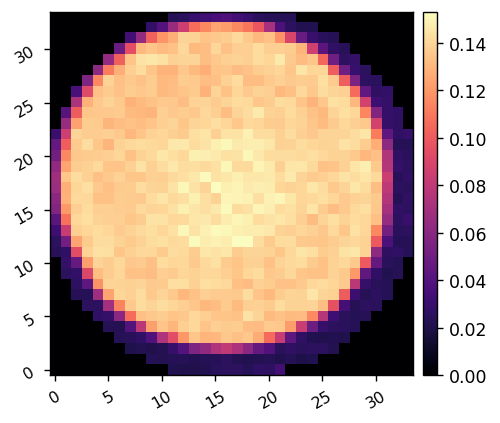

In [4]:
dmmap = fits.getdata('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/dmmap.fits')
imshow1(dmmap)

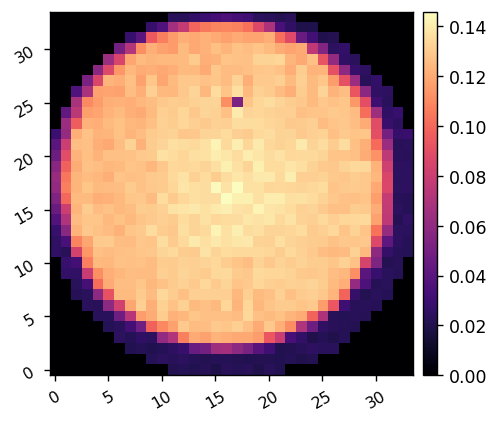

In [3]:
dmmap = fits.getdata('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/dmmap.fits')
imshow1(dmmap)

In [140]:
config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')
fitdict, Imeas_cen = console.estimate_oneshot(config_params)

INFO:utils:Got semaphore index 1.


/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:536: RuntimeWarning: divide by zero encountered in log
  amp_lnrms = np.std(np.log(amp_norm)[amp_mask])#rms(np.log(amp_norm), pupil)
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:124: RuntimeWarning: divide by zero encountered in log
  log_amp = np.log(amp)
INFO:fdpr2:Estimated phase RMS: 0.198 (rad)
INFO:fdpr2:Estimated amplitude RMS: 7.28 (%)
INFO:fdpr2:Estimated Strehl: 0.96 (0.96 phase-only and 0.99 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


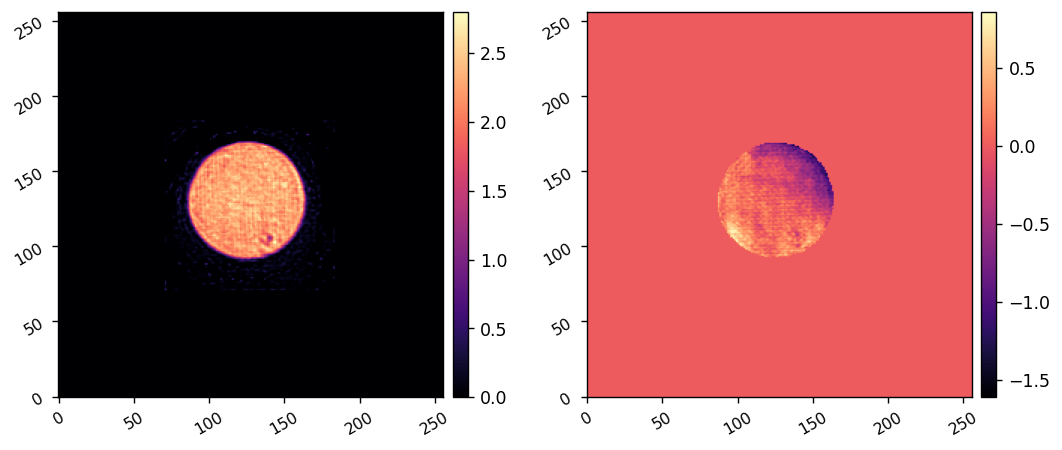

In [141]:
imshow2(fitdict['amp_est'], fitdict['phase_est'])

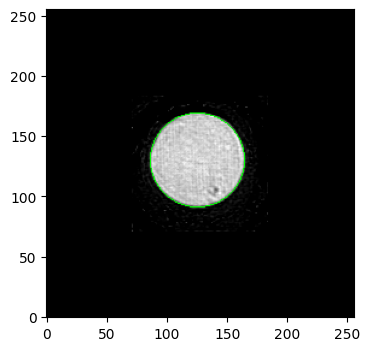

In [142]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

# Load picture and detect edges
# image = img_as_ubyte(data.coins()[160:230, 70:270])
image = img_as_ubyte(fitdict['amp_est']/np.max(fitdict['amp_est']))
# image = img_as_ubyte(np.abs(fitdict['phase_est'])/np.max(np.abs(fitdict['phase_est'])))
edges = canny(image, sigma=1, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(30, 45, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (0, 255, 0)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

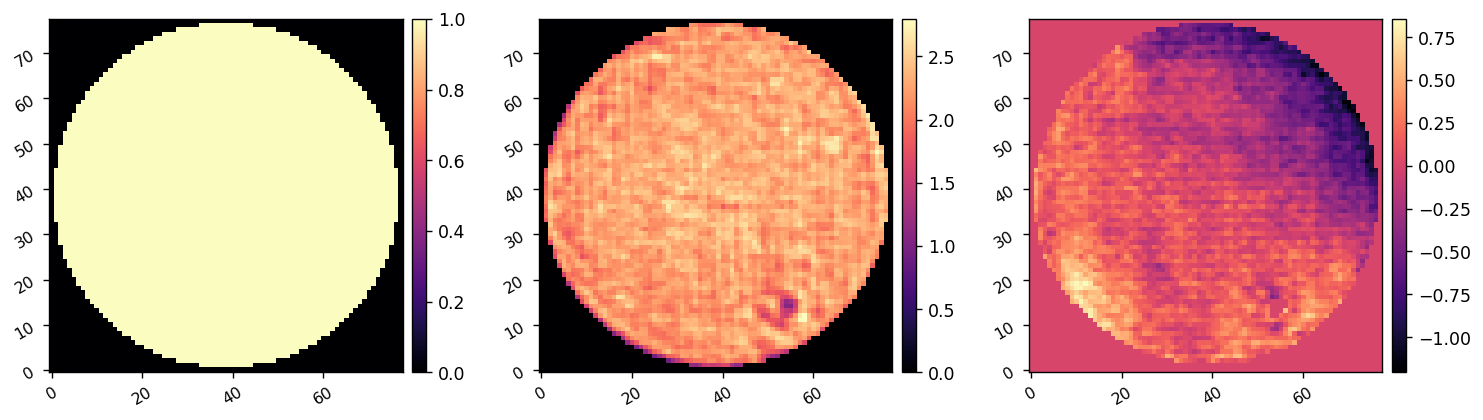

In [143]:
amp_est = fitdict['amp_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_est = fitdict['phase_est'][center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
Nfit = amp_est.shape[0]
y,x = (np.indices((Nfit, Nfit)) - Nfit/2+1/2)
r = np.sqrt(x**2 + y**2)
fit_mask = r<(radii[0]-1)

amp_est *= fit_mask
phs_est *= fit_mask
imshow3(fit_mask, amp_est, phs_est)



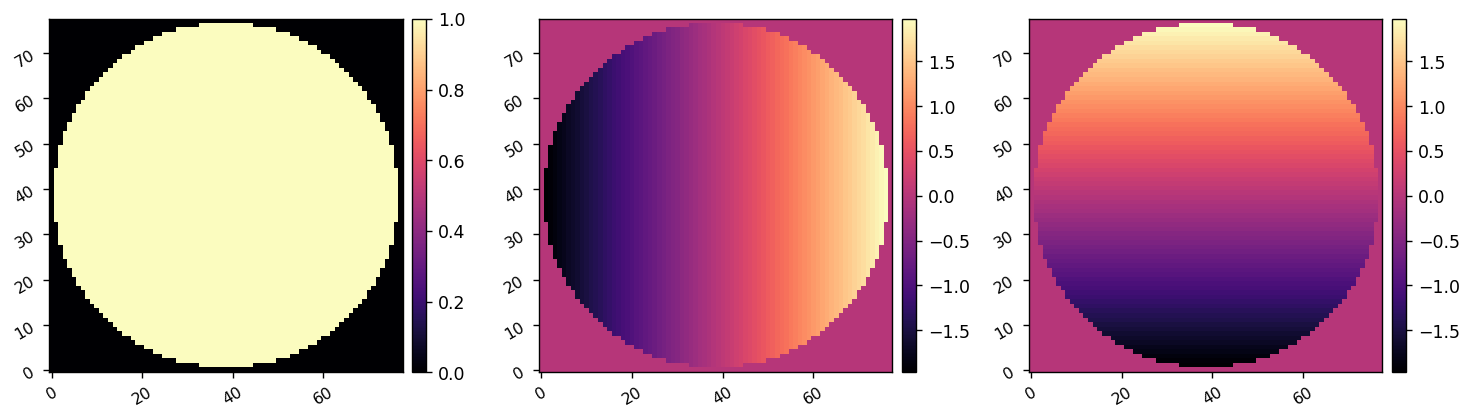

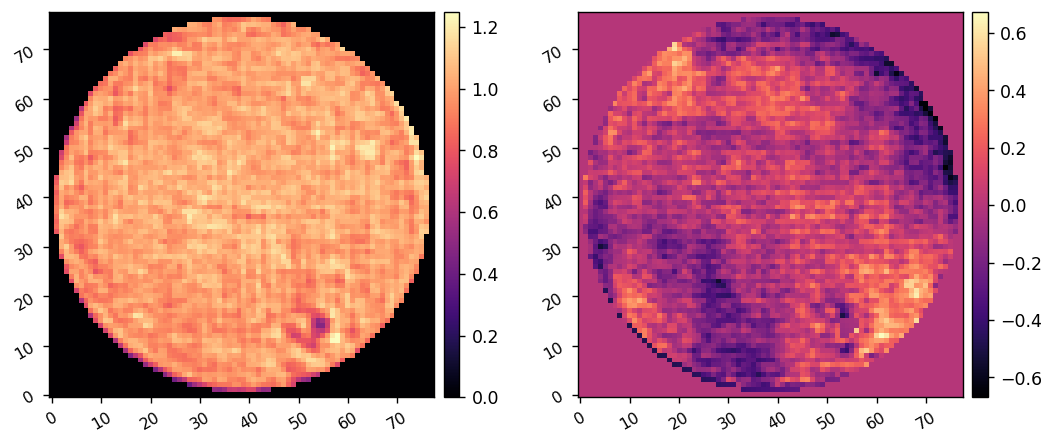

In [145]:
ptt_modes = lina.utils.create_zernike_modes(fit_mask, nmodes=3)
imshow3(ptt_modes[0], ptt_modes[1], ptt_modes[2])

ptt_coeff = lina.utils.lstsq(ptt_modes, xp.array(phs_est))
ptt = ensure_np_array( xp.sum(ptt_coeff[:, None, None] * ptt_modes, axis=0) ) 
phs_est_minus_ptt = phs_est - ptt

amp_est /= np.mean(amp_est[fit_mask])

imshow2(amp_est/np.mean(amp_est[fit_mask]), phs_est_minus_ptt)



935


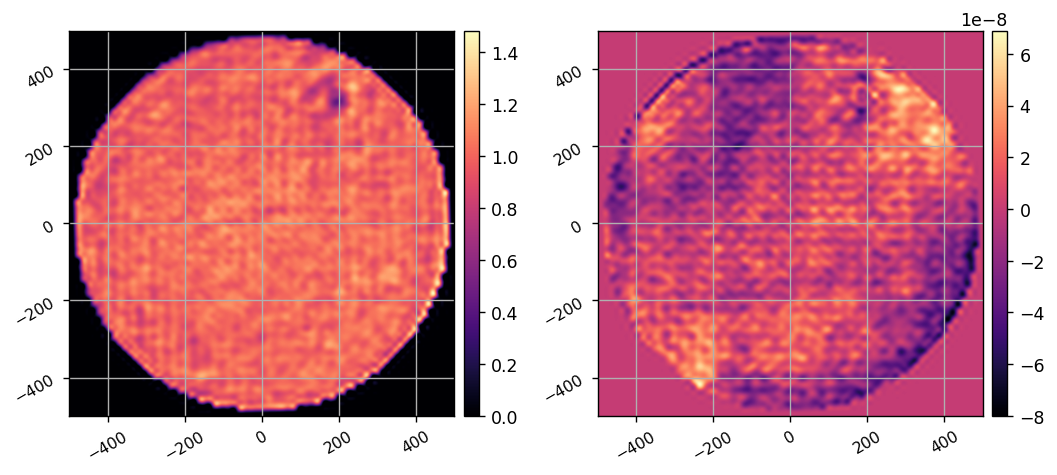

In [151]:
npix = 1000
nlyot = int(np.ceil(8.6/9.2 * npix))
print(nlyot)
shift = (-5,8)
rotation = 1.5

# iamp_est = lina.utils.interp_arr(xp.array(amp_est), 1/Nfit, 1/nlyot, order=5)
# iphs_est = lina.utils.interp_arr(xp.array(phs_est_minus_ptt), 1/Nfit, 1/nlyot, order=5)
iamp_est = lina.utils.interp_arr(xp.array(amp_est), 1/Nfit, 1/npix, order=5)
iphs_est = lina.utils.interp_arr(xp.array(phs_est_minus_ptt), 1/Nfit, 1/npix, order=5)

iamp_est = lina.utils.rotate_arr(iamp_est, rotation, reshape=False, order=5)
iphs_est = lina.utils.rotate_arr(iphs_est, rotation, reshape=False, order=5)

iamp_est = xp.flipud(iamp_est)
iphs_est = xp.flipud(iphs_est)

iamp_est = _scipy.ndimage.shift(iamp_est, shift)
iphs_est = _scipy.ndimage.shift(iphs_est, shift)

iamp_est[iamp_est<0] = 0
iopd_est = iphs_est * wavelength / (2*np.pi)

imshow2(iamp_est, iopd_est, pxscl=1, grid=True)


In [153]:
iamp_est.shape

(999, 999)

In [152]:
lina.utils.save_fits('data/pr_est_amp.fits', iamp_est)
lina.utils.save_fits('data/pr_est_opd.fits', iopd_est)

Saved data to:  data/pr_est_amp.fits
Saved data to:  data/pr_est_opd.fits
